In [5]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

symbol = 'USD'
files = sorted(os.listdir(f'data/{symbol}'), key=lambda f: f'{f:>7}')


In [6]:
results = []
leverage = {}
for f in files:
    df = pd.read_csv(f'data/{symbol}/{f}')
    df.start_date = pd.to_datetime(df.start_date)
    df.end_date = pd.to_datetime(df.end_date)
    df['TTL'] = ((df.end_date - df.start_date).dt.days / 7).round(0)
    call_profits = df.call_end_price / df.call_start_price - 1
    mean_call_profit = call_profits.mean()
    annual_call_profit = (call_profits / df.TTL * 52).mean()
    positive_ratio = (call_profits > 0).mean()
    call_leverage = (df.call_strike_price / df.call_start_price).median()
    print(f'[{f:>7}] '
          f'mean profit: {mean_call_profit:+5.0%} '
          f'positive: {positive_ratio:5.0%} '
          f'leverage: {call_leverage:4.1f} '
        #   f'daily tx: {df.call_daily_tx.median():4.0f} '
          f'transactions: {len(df):3d} ')
    results.append({
        'profit': mean_call_profit,
        'positive': positive_ratio,
    })

    w = int(re.match(r'\d+', f)[0])
    leverage[w] = call_leverage    

[ 1w.csv] mean profit:  +26% positive:   30% leverage: 39.8 transactions:  20 
[ 2w.csv] mean profit: +123% positive:   53% leverage: 26.9 transactions:  17 
[ 3w.csv] mean profit:  +29% positive:   43% leverage: 19.8 transactions:  23 
[ 4w.csv] mean profit: +155% positive:   57% leverage: 18.0 transactions:  14 
[ 5w.csv] mean profit:  +85% positive:   43% leverage: 15.1 transactions:  14 
[ 6w.csv] mean profit: +146% positive:   50% leverage: 13.3 transactions:  16 
[ 7w.csv] mean profit:  +90% positive:   38% leverage: 13.8 transactions:   8 
[ 8w.csv] mean profit:  +73% positive:   60% leverage: 10.5 transactions:  10 
[ 9w.csv] mean profit:  -36% positive:   25% leverage:  8.6 transactions:   4 
[10w.csv] mean profit:  -95% positive:    0% leverage:  8.1 transactions:   1 
[11w.csv] mean profit:  -54% positive:    0% leverage:  9.4 transactions:   1 
[12w.csv] mean profit:  +31% positive:  100% leverage:  7.6 transactions:   1 
[13w.csv] mean profit: -100% positive:    0% leverag

In [7]:
leverage

{1: 39.78571428571429,
 2: 26.896551724137932,
 3: 19.767441860465116,
 4: 18.01948051948052,
 5: 15.074595055413472,
 6: 13.310023310023311,
 7: 13.772609819121445,
 8: 10.511111111111111,
 9: 8.607171000788021,
 10: 8.075040783034257,
 11: 9.405940594059405,
 12: 7.596067917783736,
 13: 8.064516129032258,
 14: 9.545454545454545,
 15: 8.239064856711916,
 16: 7.965276943409828,
 17: 7.669755836749243,
 18: 5.916666666666666,
 19: 7.142857142857143,
 20: 6.791492553305475,
 21: 6.734068627450981,
 22: 6.553398058252427,
 23: 5.633802816901409,
 26: 6.4032697547683926}

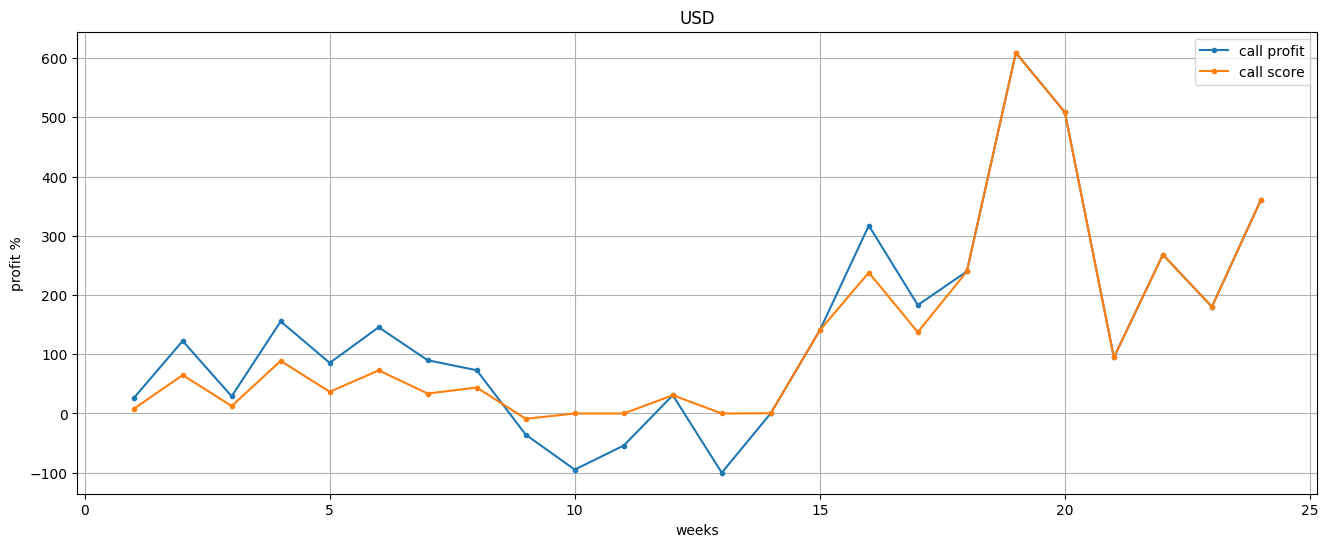

In [8]:
plt.figure(figsize=(16,6))
plt.plot([None]+[r['profit'] * 100 for r in results], label='call profit', marker='.')
plt.plot([None]+[r['profit'] * r['positive'] * 100 for r in results], label='call score', marker='.')
plt.legend(loc='best')
plt.title(symbol)
plt.xlabel('weeks')
plt.ylabel('profit %')
plt.grid()
plt.show()

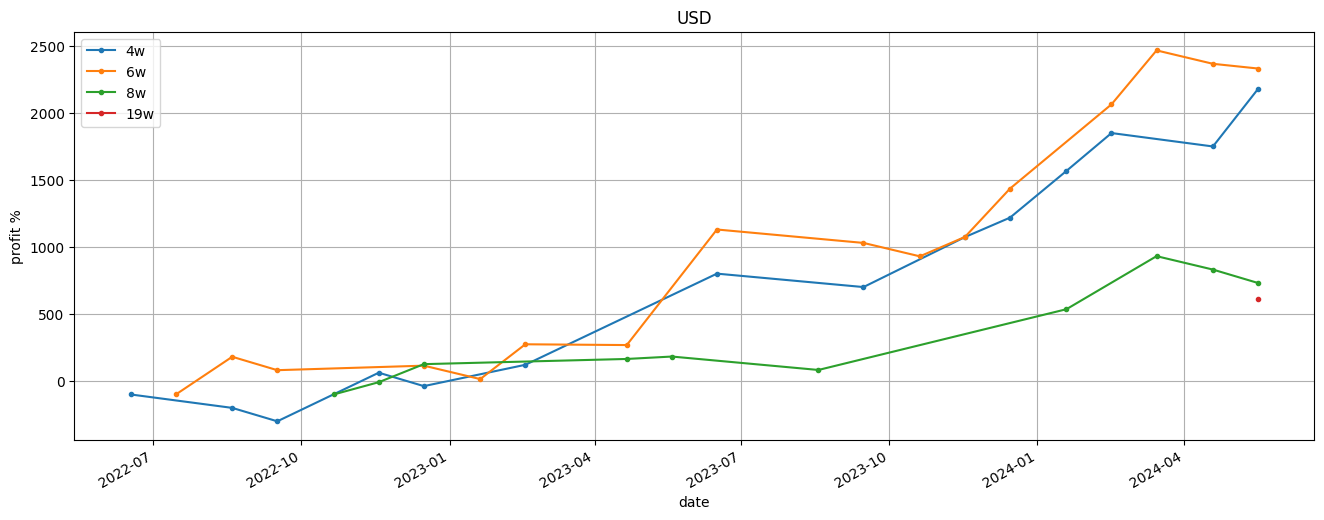

In [9]:
plt.figure(figsize=(16,6))

for n in [4,6,8,19]:
    k = f'{n}w'
    df = pd.read_csv(f'data/{symbol}/{k}.csv')
    df.end_date = pd.to_datetime(df.end_date)
    df = df.set_index('end_date')
    df[k] = (df.call_end_price / df.call_start_price - 1) * 100
    df[k].cumsum().plot(marker='.')

plt.legend(loc='best')
plt.title(symbol)
plt.xlabel('date')
plt.ylabel('profit %')
plt.grid()
plt.show()

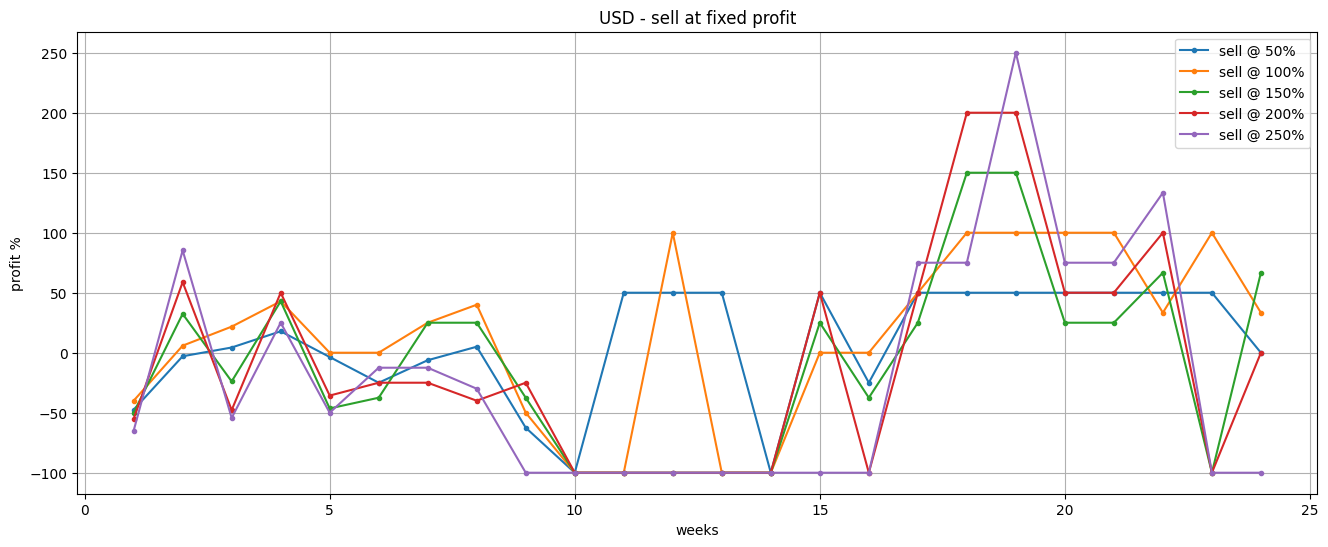

In [10]:
profit_thresholds = [0.5,1,1.5,2,2.5]
results = []
for f in files:
    df = pd.read_csv(f'data/{symbol}/{f}')
    df.start_date = pd.to_datetime(df.start_date)
    df.end_date = pd.to_datetime(df.end_date)
    df['TTL'] = ((df.end_date - df.start_date).dt.days / 7).round(0)
    call_max_profits = df.call_max_price / df.call_start_price - 1
    weeks = df.TTL.median()
    r = {}
    for p in profit_thresholds:
        q = (call_max_profits >= p).mean()
        r[p] = (q * (p + 1) - 1) #* 52 / weeks
    results.append(r)

plt.figure(figsize=(16,6))

for p in profit_thresholds:
    plt.plot([None]+[r[p] * 100 for r in results], label=f'sell @ {p:.0%}', marker='.')

plt.legend(loc='best')
plt.title(symbol + ' - sell at fixed profit')
plt.xlabel('weeks')
plt.ylabel('profit %')
plt.grid()
plt.show()

In [11]:
df = pd.read_csv(f'data/{symbol}/2w.csv')
df.end_date = pd.to_datetime(df.end_date)
df = df.set_index('end_date')
df['call_max_profit'] = df.call_max_price / df.call_start_price - 1
for p in [0.45,0.5,0.55,1,2,2.5]:
    q = (df['call_max_profit'] >= p).mean()
    profit = q * (p + 1) - 1
    print(f'sell @ {p:4.0%}: success rate {q:.0%} = profit: {profit:3.0%} ({profit*52:5.0%} p.a.)')

sell @  45%: success rate 65% = profit: -6% (-321% p.a.)
sell @  50%: success rate 65% = profit: -3% (-153% p.a.)
sell @  55%: success rate 59% = profit: -9% (-459% p.a.)
sell @ 100%: success rate 53% = profit:  6% ( 306% p.a.)
sell @ 200%: success rate 53% = profit: 59% (3059% p.a.)
sell @ 250%: success rate 53% = profit: 85% (4435% p.a.)


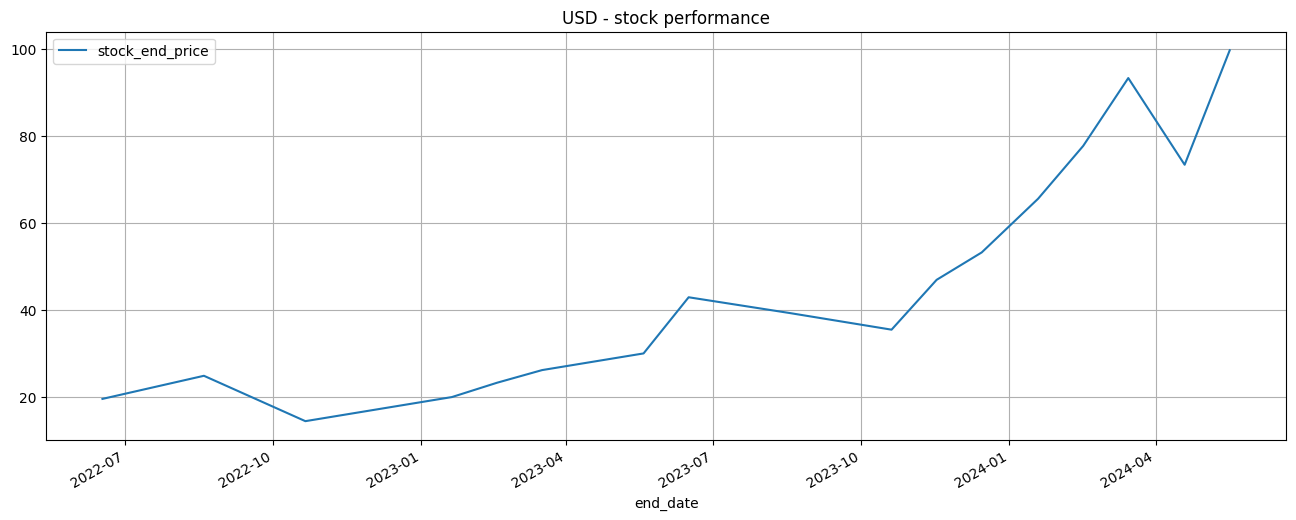

In [12]:
plt.figure(figsize=(16,6))
plt.title(symbol + ' - stock performance')
df.stock_end_price.plot()
plt.legend(loc='best')
plt.grid()